# PyTorch Deep Explainer MNIST example

A simple example showing how to explain an MNIST CNN trained using PyTorch with Deep Explainer.

In [107]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

import shap

In [108]:
batch_size = 128
num_epochs = 5
device = torch.device("cpu")


class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
                f" ({100.0 * batch_idx / len(train_loader):.0f}%)]"
                f"\tLoss: {loss.item():.6f}"
            )


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        f"\nTest set: Average loss: {test_loss:.4f},"
        f" Accuracy: {correct}/{len(test_loader.dataset)}"
        f" ({100.0 * correct / len(test_loader.dataset):.0f}%)\n"
    )


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "mnist_data",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor()]),
    ),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("mnist_data", train=False, transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=batch_size,
    shuffle=True,
)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.321612
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.135058
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.374807
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.809731
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.687391

Test set: Average loss: 0.0043, Accuracy: 9016/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.429477
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.626634
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.479921
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.544505
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.378205

Test set: Average loss: 0.0024, Accuracy: 9448/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.483425
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.346997
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.353922
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.344896
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.483301

Test set: Average loss: 0.0017, Accuracy: 9562/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.339805
Train Epoch: 4 [12800/60000 (21%)]	Lo

In [116]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, labels = batch

background = images[:1000]
test_images = images[100:103]
print(f"background shape: {background.shape}")

predLabel100 = model(test_images[0])
print(f"predLabel100: {predLabel100}")

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

# predictedLabels are the predicted class probabilities with 2 decimals
predictedLabels = np.round(model(test_images).detach().numpy(), 2)
print(f"predicted labels: {predictedLabels}")
trueLabels = labels[100:103].detach().numpy()
# make trueLabels a python list
trueLabels = [int(x) for x in trueLabels]

print(f"test_images shape: {test_images.shape}")
# test image true labels
print(f"true labels: {trueLabels}")
print(f"true labels type: {type(trueLabels)}")
print(f"shap_values shape: {shap_values.shape}")


background shape: torch.Size([128, 1, 28, 28])
predLabel100: tensor([[2.8469e-02, 5.9705e-04, 1.5315e-02, 5.5626e-01, 9.3514e-05, 3.9525e-01,
         1.8573e-03, 7.1244e-04, 9.2864e-04, 5.0927e-04]],
       grad_fn=<SoftmaxBackward0>)
predicted labels: [[0.03 0.   0.02 0.56 0.   0.4  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.01 0.98 0.   0.01 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.99 0.   0.01]]
test_images shape: torch.Size([3, 1, 28, 28])
true labels: [3, 6, 7]
true labels type: <class 'list'>
shap_values shape: (3, 1, 28, 28, 10)


In [ ]:
shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
print(f"shap_values shape: {shap_values.shape}")
print(f"shap_numpy len: {len(shap_numpy)}")
print(f"shap_numpy[0] shape: {shap_numpy[0].shape}")
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
print(f"test_numpy shape: {test_numpy.shape}")
print(f"test_images shape: {test_images.shape}")

shap_values shape: (3, 1, 28, 28, 10)
shap_numpy length: 10
shap_numpy[0] shape: (3, 28, 28, 1)
test_numpy shape: (3, 28, 28, 1)
test_images shape: torch.Size([3, 1, 28, 28])


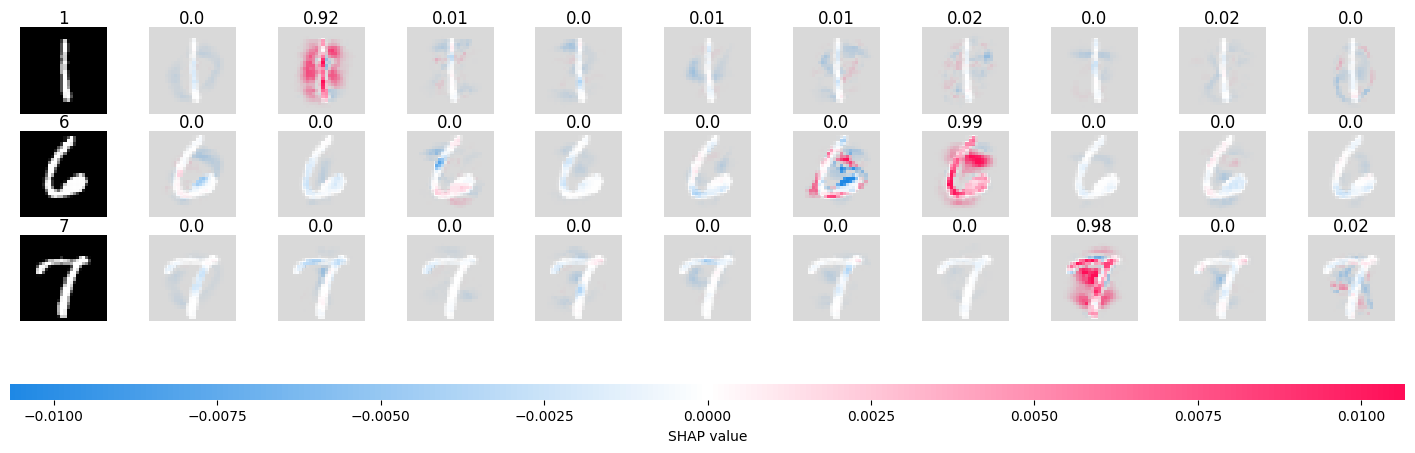

In [111]:
# plot the feature attributions
shap.image_plot(shap_values=shap_numpy,
                pixel_values=test_numpy,
                labels=predictedLabels,
                true_labels=trueLabels,
                labelpad=0,
                width=18)

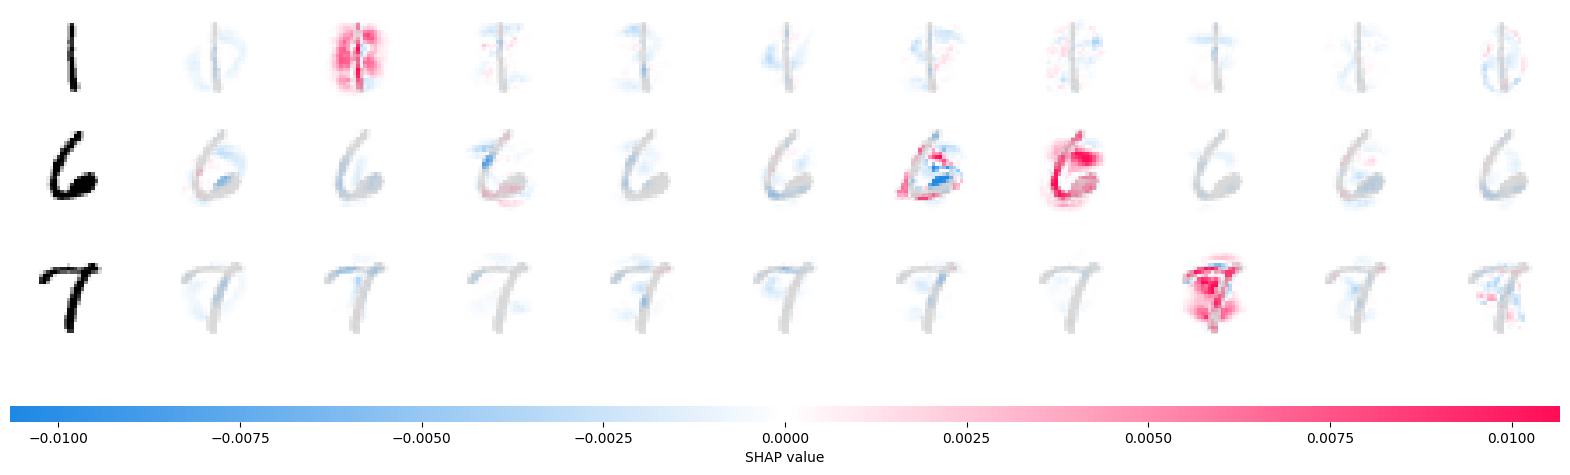

In [112]:
shap.image_plot(shap_numpy, -test_numpy)




The plot above shows the explanations for each class on four predictions. Note that the explanations are ordered for the classes 0-9 going left to right along the rows.